In [ ]:
!nvidia-smi

Tue Mar  8 05:02:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Ultralytics Yolo v3 설치

In [ ]:
!git clone https://github.com/ultralytics/yolov3
!cd yolov3;pip install -qr requirements.txt

Cloning into 'yolov3'...
remote: Enumerating objects: 9976, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 9976 (delta 3), reused 8 (delta 2), pack-reused 9964
Receiving objects: 100% (9976/9976), 9.32 MiB | 13.33 MiB/s, done.
Resolving deltas: 100% (6723/6723), done.
     |████████████████████████████████| 596 kB 4.1 MB/s 
     |████████████████████████████████| 1.7 MB 92.7 MB/s 
     |████████████████████████████████| 181 kB 93.7 MB/s 
     |████████████████████████████████| 144 kB 91.9 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 


In [ ]:
import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.10.0+cu111 (Tesla P100-PCIE-16GB)


### Oxford Pet Dataset 다운로드
* Oxford Pet 데이터를 다운로드 후 /content/data 디렉토리에 압축 해제. 

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

--2022-03-08 05:02:20--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  12.0MB/s    in 65s     

2022-03-08 05:03:26 (11.6 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2022-03-08 05:03:26--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  5.69MB/s    in 3.2s    

2022-03-08 05:03:31 (5.69 M

In [ ]:
# /content/data 디렉토리를 만들고 해당 디렉토리에 다운로드 받은 압축 파일 풀기.
!mkdir /content/data
!tar -xvf images.tar.gz -C /content/data
!tar -xvf annotations.tar.gz -C /content/data

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annota

### Oxford Pet Dataset 리뷰 및 학습/검증 데이터 세트로 분리
* Format보다 Directory 구조부터 맞추는 게 편함
*  Pandas DataFrame으로 메타데이터 생성하고 이를 이용하여 학습과 검증 데이터 세트로 분리

**1) Directory  + Format쌍이 맞아야함**         
**2) 1)을 기반해서 DAtaset config yaml 생성**    
**1-1) Ultralytics Annotation format으로 변환 -> format이 하나의 이미지는 하나의 anno와 매핑 (anno : classid, centerx, centery, w, h )인데 centerx ~ h가 0~1사이의 값으로 Normalization되어서 저장돼있음**

In [ ]:
# Ultralytics Yolo images와 labels 디렉토리를 train, val 용으로 생성
!mkdir /content/ox_pet;
!cd /content/ox_pet; mkdir images; mkdir labels;
!cd /content/ox_pet/images; mkdir train; mkdir val
!cd /content/ox_pet/labels; mkdir train; mkdir val

In [ ]:
import pandas as pd 

pd.read_csv('/content/data/annotations/trainval.txt', sep=' ', header=None, names=['img_name', 'class_id', 'etc1', 'etc2'])

,img_name,class_id,etc1,etc2
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1
...,...,...,...,...
3675,yorkshire_terrier_187,37,2,25
3676,yorkshire_terrier_188,37,2,25
3677,yorkshire_terrier_189,37,2,25
3678,yorkshire_terrier_18,37,2,25


In [ ]:
# '''
for index, row in pet_df.iterrows():
  print(index, row  )
# '''

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
3053 img_name                                            pomeranian_166
class_id                                                        25
etc1                                                             2
etc2                                                            17
class_name                                              pomeranian
img_filepath               /content/data/images/pomeranian_166.jpg
anno_filepath    /content/data/annotations/xmls/pomeranian_166.xml
Name: 3053, dtype: object
3054 img_name                                            pomeranian_167
class_id                                                        25
etc1                                                             2
etc2                                                            17
class_name                                              pomeranian
img_filepath               /content/data/images/pomeranian_167.jpg
anno_filepath    /content/data/annotations/xmls/pomerania

In [ ]:
# '''
for index, row in pet_df.iterrows():
  print(index, row['anno_filepath'])
# '''

0 /content/data/annotations/xmls/Abyssinian_100.xml
1 /content/data/annotations/xmls/Abyssinian_101.xml
2 /content/data/annotations/xmls/Abyssinian_102.xml
3 /content/data/annotations/xmls/Abyssinian_103.xml
5 /content/data/annotations/xmls/Abyssinian_105.xml
6 /content/data/annotations/xmls/Abyssinian_106.xml
7 /content/data/annotations/xmls/Abyssinian_107.xml
8 /content/data/annotations/xmls/Abyssinian_108.xml
9 /content/data/annotations/xmls/Abyssinian_109.xml
10 /content/data/annotations/xmls/Abyssinian_10.xml
11 /content/data/annotations/xmls/Abyssinian_110.xml
12 /content/data/annotations/xmls/Abyssinian_111.xml
13 /content/data/annotations/xmls/Abyssinian_112.xml
14 /content/data/annotations/xmls/Abyssinian_113.xml
15 /content/data/annotations/xmls/Abyssinian_114.xml
16 /content/data/annotations/xmls/Abyssinian_115.xml
17 /content/data/annotations/xmls/Abyssinian_116.xml
18 /content/data/annotations/xmls/Abyssinian_117.xml
19 /content/data/annotations/xmls/Abyssinian_118.xml
20 

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# 전체 image/annotation 파일명을 가지는 리스트 파일명을 입력 받아 메타 파일용 DataFrame 및 학습/검증용 DataFrame 생성. 
def make_train_valid_df(list_filepath, img_dir, anno_dir, test_size=0.1):
  pet_df = pd.read_csv(list_filepath, sep=' ', header=None, names=['img_name', 'class_id', 'etc1', 'etc2'])

  #class_name은 image 파일명에서 맨 마지막 '_' 문자열 앞까지에 해당. 
  pet_df['class_name'] = pet_df['img_name'].apply(lambda x:x[:x.rfind('_')])
  
  # image 파일명과 annotation 파일명의 절대경로 컬럼 추가
  pet_df['img_filepath'] = img_dir + pet_df['img_name']+'.jpg'
  pet_df['anno_filepath'] = anno_dir + pet_df['img_name']+'.xml'

  # annotation xml 파일이 없는데, trainval.txt에는 리스트가 있는 경우가 있음. 이들의 경우 pet_df에서 해당 rows를 삭제함. 
  pet_df = remove_no_annos(pet_df)

  # 전체 데이터의 10%를 검증 데이터로, 나머지는 학습 데이터로 분리. 
  train_df, val_df = train_test_split(pet_df, test_size=test_size, stratify=pet_df['class_id'], random_state=2021)
  return pet_df, train_df, val_df

# annotation xml 파일이 없는데, trainval.txt에는 리스트가 있는 경우에 이들을 dataframe에서 삭제하기 위한 함수.
def remove_no_annos(df):
  remove_rows = []
  for index, row in df.iterrows(): # index : df의 고유한 키값 / row : 데이터 다 가져옴
    anno_filepath = row['anno_filepath']
    if not os.path.exists(anno_filepath):
      print('##### index:', index, anno_filepath, '가 존재하지 않아서 Dataframe에서 삭제함')
      #해당 DataFrame index를 remove_rows list에 담음. 
      remove_rows.append(index)
  # DataFrame의 index가 담긴 list를 drop()인자로 입력하여 해당 rows를 삭제
  df = df.drop(remove_rows, axis=0, inplace=False)
  return df


pet_df, train_df, val_df = make_train_valid_df('/content/data/annotations/trainval.txt', 
                                               '/content/data/images/', '/content/data/annotations/xmls/', test_size=0.1)

##### index: 4 /content/data/annotations/xmls/Abyssinian_104.xml 가 존재하지 않아서 Dataframe에서 삭제함
##### index: 262 /content/data/annotations/xmls/Bengal_111.xml 가 존재하지 않아서 Dataframe에서 삭제함
##### index: 1456 /content/data/annotations/xmls/samoyed_10.xml 가 존재하지 않아서 Dataframe에서 삭제함
##### index: 2128 /content/data/annotations/xmls/Bengal_175.xml 가 존재하지 않아서 Dataframe에서 삭제함
##### index: 2395 /content/data/annotations/xmls/Egyptian_Mau_14.xml 가 존재하지 않아서 Dataframe에서 삭제함
##### index: 2402 /content/data/annotations/xmls/Egyptian_Mau_156.xml 가 존재하지 않아서 Dataframe에서 삭제함
##### index: 2427 /content/data/annotations/xmls/Egyptian_Mau_186.xml 가 존재하지 않아서 Dataframe에서 삭제함
##### index: 3177 /content/data/annotations/xmls/Ragdoll_199.xml 가 존재하지 않아서 Dataframe에서 삭제함
##### index: 3246 /content/data/annotations/xmls/saint_bernard_15.xml 가 존재하지 않아서 Dataframe에서 삭제함


In [ ]:
#print(train_df['class_name'].value_counts())
pet_df.head()

,img_name,class_id,etc1,etc2,class_name,img_filepath,anno_filepath
0,Abyssinian_100,1,1,1,Abyssinian,/content/data/images/Abyssinian_100.jpg,/content/data/annotations/xmls/Abyssinian_100.xml
1,Abyssinian_101,1,1,1,Abyssinian,/content/data/images/Abyssinian_101.jpg,/content/data/annotations/xmls/Abyssinian_101.xml
2,Abyssinian_102,1,1,1,Abyssinian,/content/data/images/Abyssinian_102.jpg,/content/data/annotations/xmls/Abyssinian_102.xml
3,Abyssinian_103,1,1,1,Abyssinian,/content/data/images/Abyssinian_103.jpg,/content/data/annotations/xmls/Abyssinian_103.xml
5,Abyssinian_105,1,1,1,Abyssinian,/content/data/images/Abyssinian_105.jpg,/content/data/annotations/xmls/Abyssinian_105.xml


In [ ]:
import os

for index, row in pet_df.iterrows():
  anno_filepath = row['anno_filepath']
  if not os.path.exists(anno_filepath):
    print(anno_filepath)

### Oxford Pet 데이터 세트의 annotation을 Ultralytics Yolo format으로 생성.
* annotation용 xml 파일을 txt 파일로 변환
* 하나의 이미지는 하나의 txt 파일로 변환
* 확장자를 제외한 이미지의 파일명과 annotation 파일명이 서로 동일해야 함. 
* 하나의 xml annotation 파일을 Yolo 포맷용 txt 파일로 변환하는 함수 생성
* voc annotation의 좌상단(Top left: x1, y1), 우하단(Bottom right: x2, y2) 좌표를 Bounding Box 중심 좌표(Center_x, Center_y)와 너비(width), 높이(height)로 변경
* 중심 좌표와 너비, 높이는 원본 이미지 레벨로 scale 되어야 함. 모든 값은 0~1 사이 값으로 변환됨. 
* class_id는 여러개의 label들을 0 부터 순차적으로 1씩 증가시켜 id 부여

In [ ]:
# Class 명을 부여. Class id는 자동적으로 CLASS_NAMES 개별 원소들을 순차적으로 0부터 36까지 부여
CLASS_NAMES = pet_df['class_name'].unique().tolist()
print(CLASS_NAMES)

['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer', 'British_Shorthair', 'chihuahua', 'Egyptian_Mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'Maine_Coon', 'miniature_pinscher', 'newfoundland', 'Persian', 'pomeranian', 'pug', 'Ragdoll', 'Russian_Blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'Siamese', 'Sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


In [ ]:
import glob
import xml.etree.ElementTree as ET

# 1개의 voc xml 파일을 Yolo 포맷용 txt 파일로 변경하는 함수 
def xml_to_txt(input_xml_file, output_txt_file, object_name):

  # ElementTree로 입력 XML파일 파싱. 
  tree = ET.parse(input_xml_file)
  root = tree.getroot() # pet data의 annotation xml 파일에서 annotation 접근
  img_node = root.find('size')

  # img_node를 찾지 못하면 종료
  if img_node is None:
    return None

  # 원본 이미지의 너비와 높이 추출. 
  img_width = int(img_node.find('width').text)
  img_height = int(img_node.find('height').text)

  # xml 파일내에 있는 모든 object Element를 찾음. 
  # output_txt_file : 5개의 컬럼으로 구성된 yolo format file
  value_str = None
  with open(output_txt_file, 'w') as output_fpointer:
    for obj in root.findall('object'):

        # bndbox를 찾아서 좌상단(xmin, ymin), 우하단(xmax, ymax) 좌표 추출. 
        xmlbox = obj.find('bndbox')
        x1 = int(xmlbox.find('xmin').text)
        y1 = int(xmlbox.find('ymin').text)
        x2 = int(xmlbox.find('xmax').text)
        y2 = int(xmlbox.find('ymax').text)

        # 만약 좌표중에 하나라도 0보다 작은 값이 있으면 종료. 
        if (x1 < 0) or (x2 < 0) or (y1 < 0) or (y2 < 0):
          break

        # object_name과 원본 좌표를 입력하여 Yolo 포맷으로 변환하는 convert_yolo_coord()함수 호출. 
        class_id, cx_norm, cy_norm, w_norm, h_norm = convert_yolo_coord(object_name, img_width, img_height, x1, y1, x2, y2)
        
        # 변환된 yolo 좌표를 object 별로 출력 text 파일에 write
        value_str = ('{0} {1} {2} {3} {4}').format(class_id, cx_norm, cy_norm, w_norm, h_norm)
        output_fpointer.write(value_str+'\n')
        # debugging용으로 아래 출력
        #print(object_name, value_str)

# object_name과 원본 좌표를 입력하여 Yolo 포맷으로 변환
# 상단에서 좌상단, 우하단 좌표 추출한 것을 인자로 입력
def convert_yolo_coord(object_name, img_width, img_height, x1, y1, x2, y2):

  # class_id는 CLASS_NAMES 리스트에서 index 번호로 추출. 
  class_id = CLASS_NAMES.index(object_name)

  # 중심 좌표와 너비, 높이 계산. 
  center_x = (x1 + x2)/2
  center_y = (y1 + y2)/2
  width = x2 - x1
  height = y2 - y1

  # 원본 이미지 기준으로 중심 좌표와 너비 높이를 0-1 사이 값으로 scaling
  center_x_norm = center_x / img_width
  center_y_norm = center_y / img_height
  width_norm = width / img_width
  height_norm = height / img_height

  return class_id, round(center_x_norm, 7), round(center_y_norm, 7), round(width_norm, 7), round(height_norm, 7)


In [ ]:
 class_id = CLASS_NAMES.index('yorkshire_terrier')
 print(class_id)

36


In [ ]:
xml_to_txt('/content/data/annotations/xmls/Abyssinian_1.xml', '/content/ox_pet/labels/train/Abyssinian_1.txt', 'Abyssinian')

# class id / cx / cy / w / h
# 0 0.6316667 0.2875 0.1533333 0.215


### VOC Format의 여러개 xml 파일들을 Yolo format으로 변환 후 Ultralytics directory 구조로 입력
* VOC XML 파일들이 있는 디렉토리와 변환하여 출력될 Yolo format txt파일들이 있을 디렉토리를 입력하여 파일들을 생성. 

In [ ]:
import shutil

def make_yolo_anno_file(df, tgt_images_dir, tgt_labels_dir):
  for index, row in df.iterrows():
    src_image_path = row['img_filepath']
    src_label_path = row['anno_filepath']

    # 이미지 1개당 단 1개의 오브젝트만 존재하므로 class_name을 object_name으로 설정.  
    object_name = row['class_name']

    # yolo format으로 annotation할 txt 파일의 절대 경로명을 지정. 
    target_label_path = tgt_labels_dir + row['img_name']+'.txt'

    # image의 경우 target images 디렉토리로 단순 copy
    # Python 유틸리티 shutil 활용
    shutil.copy(src_image_path, tgt_images_dir)

    # annotation의 경우 xml 파일을 target labels 디렉토리에 Ultralytics Yolo format으로 변환하여  만듬
    xml_to_txt(src_label_path, target_label_path, object_name)

# train용 images와 labels annotation 생성. 
# train_df : source에 대한 img, label 절대 경로
make_yolo_anno_file(train_df, '/content/ox_pet/images/train/', '/content/ox_pet/labels/train/')

# val용 images와 labels annotation 생성. 
make_yolo_anno_file(val_df, '/content/ox_pet/images/val/', '/content/ox_pet/labels/val/')

### Oxford Pet Dataset 학습 수행.
* 생성된 Directory 구조에 맞춰서 dataset용 yaml 파일 생성.  

In [ ]:
!wget -O /content/ox_pet/ox_pet.yaml https://raw.githubusercontent.com/chulminkw/DLCV/master/data/util/ox_pet.yaml

--2022-03-08 05:04:16--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/util/ox_pet.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 754 [text/plain]
Saving to: ‘/content/ox_pet/ox_pet.yaml’

/content/ox_pet/ox_ 100%[===================>]     754  --.-KB/s    in 0s      

2022-03-08 05:04:17 (67.0 MB/s) - ‘/content/ox_pet/ox_pet.yaml’ saved [754/754]



In [ ]:
### train시 1시간 정도 소모 됩니다. colab환경에서 아래를 browser의 console 에서 붙여 넣기가 필요할 수 있습니다. 
### shift+cntr+i 로 browser console 열기 
# https://github.com/chulminkw/DLCV/blob/master/data/util/colab_autoclick.js
'''
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000)
'''

'\nfunction ClickConnect(){\nconsole.log("Working"); \ndocument.querySelector("colab-toolbar-button#connect").click() \n}\nsetInterval(ClickConnect,60000)\n'

In [ ]:
# Google Drive 접근을 위한 Mount 적용. 
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# soft link로 Google Drive Directory 연결. 
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

 Colab_Notebooks  'My Drive'	  Pictures
 Documents	   pet_work_dir   ultra_workdir


In [ ]:
# Google Drive 밑에 Directory 생성. 이미 생성 되어 있을 시 오류 발생. 
!mkdir "/mydrive/ultra_workdir"

mkdir: cannot create directory ‘/mydrive/ultra_workdir’: File exists


In [ ]:
###  10번 미만 epoch는 좋은 성능이 안나옴. 최소 30번 이상 epoch 적용. -->ultralytics yolo는 상대적으로 epoch를 많이 줘야함. 
# weights yolov3.pt : pretrained weight

!cd /content/yolov3; python train.py --img 640 --batch 16 --epochs 20 --data /content/ox_pet/ox_pet.yaml --weights yolov3.pt --project=/mydrive/ultra_workdir \
                                     --name pet --exist-ok 

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 2
wandb: You chose 'Use an existing W&B account'
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
train: weights=yolov3.pt, cfg=, data=/content/ox_pet/ox_pet.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=20, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=/mydrive/ultra_workdir, name=pet, exist_ok=True, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1

### 학습된 모델 파일을 이용하여 Inference 수행. 
* 이미지 파일과 영상 파일로 inference 수행. 

In [ ]:
# image 파일 inference 
!cd yolov3;python detect.py --source /content/data/images/pug_100.jpg --weights /mydrive/ultra_workdir/pet/weights/best.pt --conf 0.2 \
                            --project=/content/data/output --name=run_image --exist-ok --line-thickness 2

detect: weights=['/mydrive/ultra_workdir/pet/weights/best.pt'], source=/content/data/images/pug_100.jpg, imgsz=[640, 640], conf_thres=0.2, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/data/output, name=run_image, exist_ok=True, line_thickness=2, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv3 🚀 v9.6.0-7-g0519223 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 261 layers, 61691290 parameters, 0 gradients, 155.3 GFLOPs
image 1/1 /content/data/images/pug_100.jpg: 640x448 1 pug, Done. (0.021s)
Speed: 0.5ms pre-process, 20.5ms inference, 32.7ms NMS per image at shape (1, 3, 640, 640)
Results saved to /content/data/output/run_image


In [ ]:
### 영상 파일 download
!wget -O /content/data/ox_dog.mp4  https://github.com/chulminkw/DLCV/blob/master/data/video/ox_dog.mp4?raw=true

--2022-03-08 05:18:30--  https://github.com/chulminkw/DLCV/blob/master/data/video/ox_dog.mp4?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/chulminkw/DLCV/raw/master/data/video/ox_dog.mp4 [following]
--2022-03-08 05:18:31--  https://github.com/chulminkw/DLCV/raw/master/data/video/ox_dog.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/ox_dog.mp4 [following]
--2022-03-08 05:18:31--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/ox_dog.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent,

In [ ]:
# ultralytics yolo v3은 소스가 mp4면 자동적으로 fps 단위별 detect 수행

!cd yolov3; python detect.py --source /content/data/ox_dog.mp4 --weights /mydrive/ultra_workdir/pet/weights/best.pt \
                  --project /content/data/output --name run_video --exist-ok --line-thickness 3 --conf 0.4 --iou=0.6

detect: weights=['/mydrive/ultra_workdir/pet/weights/best.pt'], source=/content/data/ox_dog.mp4, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.6, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/data/output, name=run_video, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv3 🚀 v9.6.0-7-g0519223 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 261 layers, 61691290 parameters, 0 gradients, 155.3 GFLOPs
video 1/1 (1/727) /content/data/ox_dog.mp4: 384x640 1 yorkshire_terrier, Done. (0.021s)
video 1/1 (2/727) /content/data/ox_dog.mp4: 384x640 1 yorkshire_terrier, Done. (0.019s)
video 1/1 (3/727) /content/data/ox_dog.mp4: 384x640 1 yorkshire_terrier, Done. (0.019s)
video 1/1 (4/727) /content/data/ox_dog.mp4: 384x640 1 yorkshire_terrier, Done. (0.019s)
vid

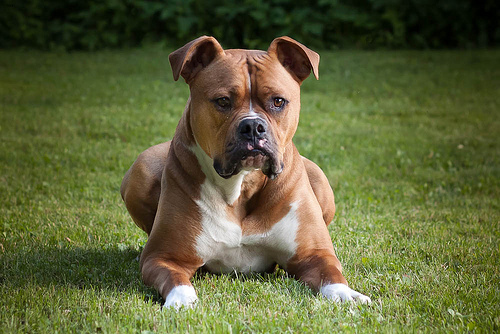

In [27]:
from IPython.display import Image, clear_output 

Image(filename='/content/data/images/american_bulldog_101.jpg', width=400)

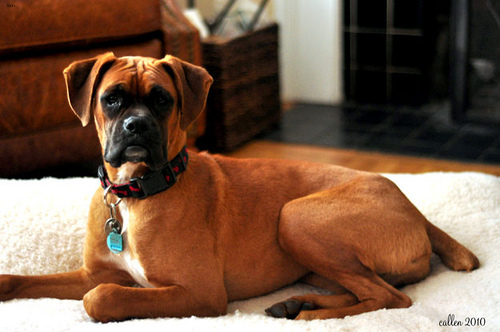

In [28]:
Image(filename='/content/data/images/boxer_100.jpg', width=400)

### test.py를 이용하여 Test 데이터를 Evalutation하기

In [29]:
# Run YOLOv3 on COCO val2017
!cd yolov3; python val.py --weights /mydrive/ultra_workdir/pet/weights/best.pt  --data /content/ox_pet/ox_pet.yaml \
                           --project /content/data/output --name=test_result --exist-ok --img 640 --iou 0.65



val: data=/content/ox_pet/ox_pet.yaml, weights=['/mydrive/ultra_workdir/pet/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.65, task=val, device=, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=/content/data/output, name=test_result, exist_ok=True, half=False, dnn=False
YOLOv3 🚀 v9.6.0-7-g0519223 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 261 layers, 61691290 parameters, 0 gradients, 155.3 GFLOPs
val: Scanning '/content/ox_pet/labels/val' images and labels...368 found, 0 missing, 0 empty, 0 corrupted: 100% 368/368 [00:00<00:00, 4084.64it/s]
val: New cache created: /content/ox_pet/labels/val.cache
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 12/12 [00:08<00:00,  1.34it/s]
                 all        368        368      0.853      0.826      0.904      0.774
          Abyssinian        36

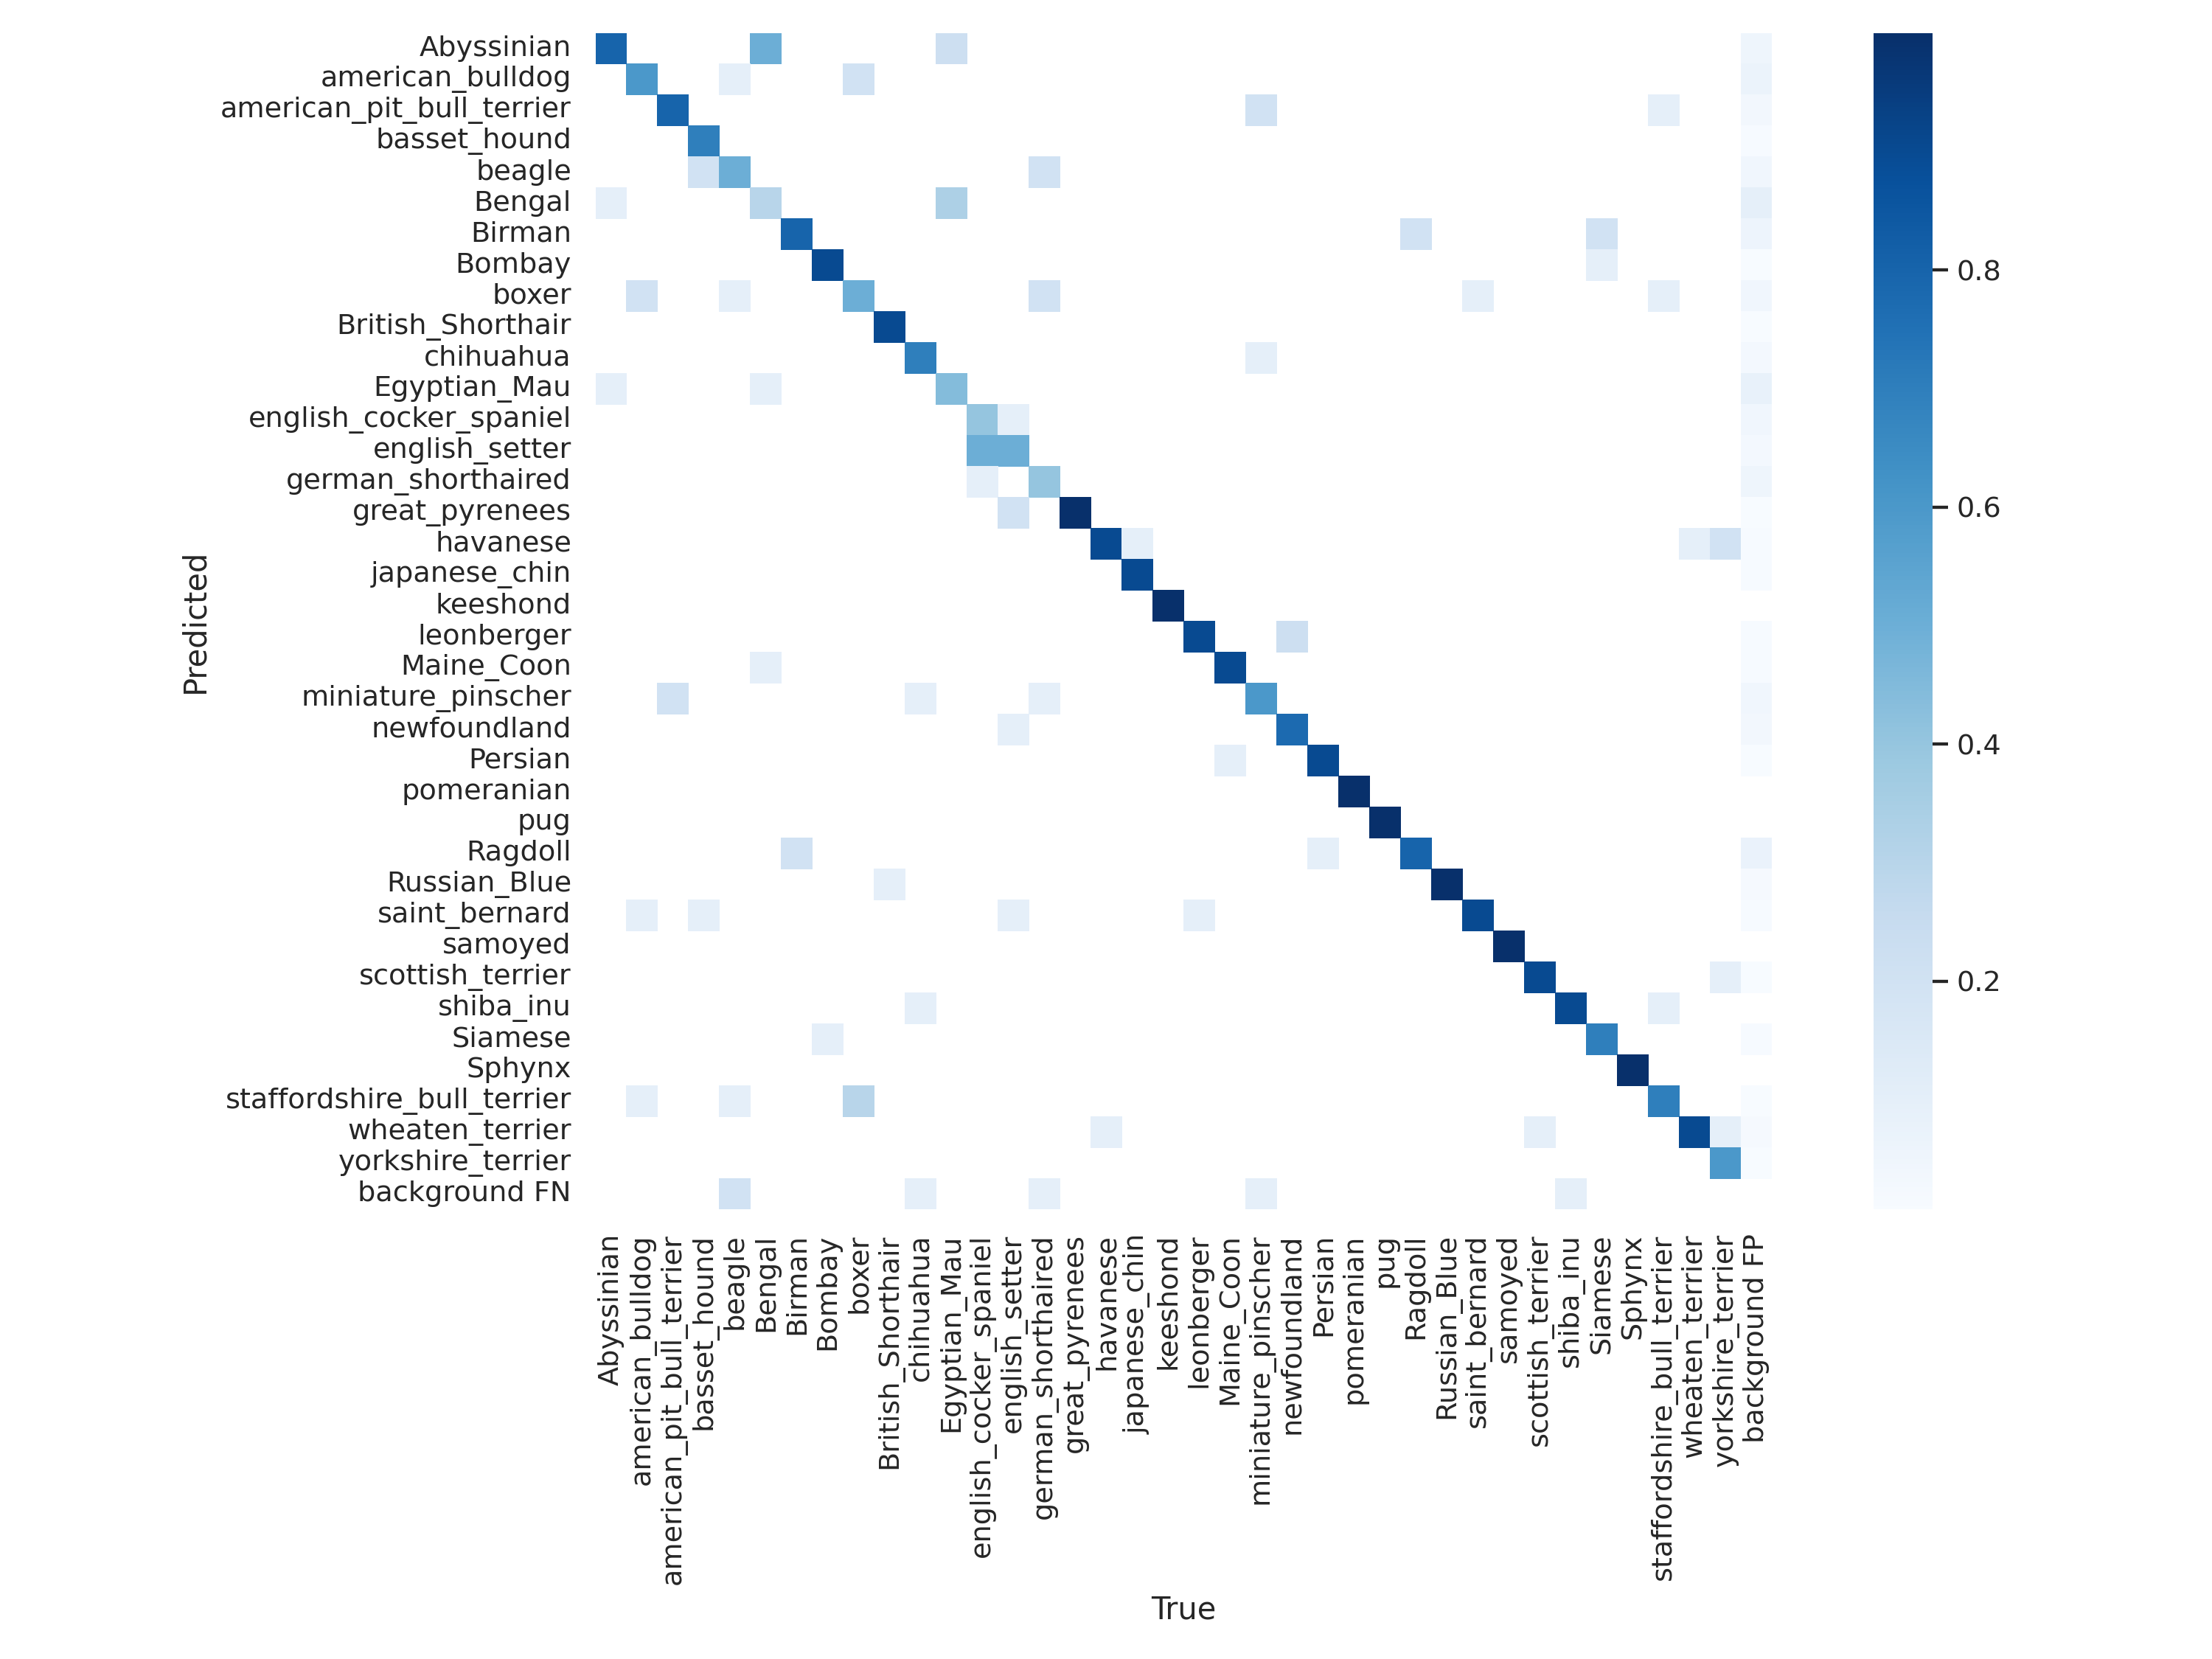

In [30]:
Image(filename='/content/data/output/test_result/confusion_matrix.png', width=800)